<a href="https://colab.research.google.com/github/niranjana1997/Twitter-Topic-Classification/blob/main/Text%20Classification%20Using%20Twitter%20and%20News%20Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Installing Libraries

In [1]:
!pip install tweepy --quiet

#####Running the code.py (which contains the Twitter API tokens) and removing the file

In [2]:
# Impoerting the code.py which contains the Twitter API tokens
%run code.py
!rm code.py

Importing required libraries

In [ ]:
import tweepy

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


import pandas as pd
import numpy as np
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

from sklearn.preprocessing import LabelEncoder

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score, confusion_matrix, matthews_corrcoef
from sklearn.metrics import precision_recall_fscore_support as score

##### Getting Data using Twitter API

In [4]:
# Authenticate to Twitter
auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
auth.set_access_token(ACCESS_TOKEN, ACCESS_TOKEN_SECRET)

# API object is created
api = tweepy.API(auth, wait_on_rate_limit=True)

# Tweets are collected using API object
politics = "election OR government OR policy OR voting OR democracy OR parliament OR Republican OR Democrat"
sports = "football OR basketball OR soccer OR tennis OR Olympics OR athletics OR swimming OR fifa OR American Football OR NFL"
entertainment = "movie OR music OR TV show OR celebrity OR award OR Oscar OR actor OR actress OR TV OR film OR Hollywood OR theatre OR cinema"
technology = 'computer OR smartphone OR software OR internet OR AI OR ChatGPT OR Artifical Intelligence OR Data Science OR robot OR robotics'
health = 'medicine OR fitness OR diet OR disease OR mental health OR covid OR hospital OR flu OR medical OR vitamin OR nutrients'
business = 'finance OR marketing OR entrepreneurship OR startup OR economy OR accounts OR NASDAQ or bank'
travel = 'vacation OR destination OR adventure OR tourism OR hotel OR flight OR airport OR airbnb OR expedia OR car rental'
food = 'recipe OR restaurant OR cooking OR cuisine OR nutrition OR vegan OR vegetarian OR grocery OR fruits OR vegetable OR meat'
education = 'school OR university OR learning OR teacher OR student OR professor OR class OR assignment OR homework OR quiz'
law = 'legal system OR court OR trial OR justice OR rights OR bail OR judge OR attorney OR lawyer'

tweets = tweepy.Cursor(api.search, q=politics, lang="en", tweet_mode='extended').items(1000)
# list of data from 'tweets' are created
tweet_data = [[tweet.id, tweet.created_at, tweet.full_text] for tweet in tweets]
# Converting list to DataFrame
tweets_df = pd.DataFrame(tweet_data, columns=["id", "created_at", "text"])
# converting dataframe to save csv
tweets_df.to_csv("Politics.csv", index=False)

#### Data Exploration & Pre-Processing

In [5]:
# Getting data from the excel file (Combined_Dataset.xlsx)
tweets_df = pd.read_excel("New Dataset - 10 Classes.xlsx")

In [6]:
# viewig the dataset before pre-processing
tweets_df

,text,label
0,Introducing Silvergate Capital. A California b...,Business
1,"RT @shaandelhite: In the Cambridge lecture, a ...",Business
2,RT @GcbGulf: Financial freedom is now a realit...,Business
3,"RT @GueshMela: "".....But, we are just survivin...",Business
4,RT @GcbGulf: Financial freedom is now a realit...,Business
...,...,...
8281,@pulte I was just in an accident that totaled ...,Travel
8282,RT @erinriediger: My transportation costs for ...,Travel
8283,RT @erinriediger: My transportation costs for ...,Travel
8284,Just booked the rental car for NYC. So many pp...,Travel


Data Pre-Processing

In [7]:
# Define pre-processing function
def preprocess_text(text):
    text = text.lower()
    # URL removed
    text = re.sub(r'http\S+|www.\S+', '', text)
    # mention and hashtag removed
    text = re.sub(r'@\S+|#S+', '', text)
    # non-ASCII removed
    text = re.sub(r'[^\x00-\x7F]+', '', text)
    # numbers removed
    text = re.sub(r'\d+', '', text)
    # whitespaces removed
    text = re.sub(r'\s+', ' ', text)
    # punctuations removed
    text = re.sub(r'[^\w\s]', '', text)
    # 'rt' / 'retweet' removed
    text = re.sub(r'\b(rt|retweet)\b', '', text.lower())
    # stopwords removed
    stop_words = set(stopwords.words('english'))
    text = ' '.join([word for word in text.split() if word.lower() not in stop_words])
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split()])
    return text

tweets_df['cleaned_text'] = tweets_df['text'].apply(preprocess_text)
tweets_df.drop_duplicates(inplace=True)

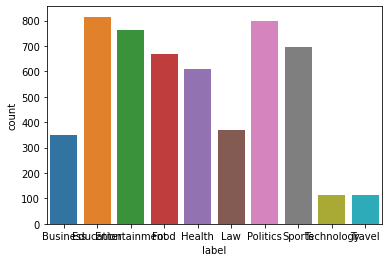

In [8]:
sns.countplot(x='label', data=tweets_df)
plt.show()

In [9]:
print(tweets_df['label'].value_counts())

Education        815
Politics         800
Entertainment    762
Sports           695
Food             670
Health           610
Law              369
Business         350
Technology       114
Travel           113
Name: label, dtype: int64


In [10]:
# label encoding
tweets_df['label_encoded'] = LabelEncoder().fit_transform(tweets_df['label'])
tweets_df

,text,label,cleaned_text,label_encoded
0,Introducing Silvergate Capital. A California b...,Business,introducing silvergate capital california bank...,0
1,"RT @shaandelhite: In the Cambridge lecture, a ...",Business,cambridge lecture question asked list good pol...,0
2,RT @GcbGulf: Financial freedom is now a realit...,Business,financial freedom reality gulf crypto bank eas...,0
3,"RT @GueshMela: "".....But, we are just survivin...",Business,surviving honest cant explain difficultnot get...,0
5,@KhadryBasha @BillyM2k Money in the bank=cash ...,Business,money bankcash normal thinking peope idea fina...,0
...,...,...,...,...
8277,I have been waiting for my Spark EV to get its...,Travel,waiting spark ev get tractionhighvoltage batte...,9
8280,RT @h_adynets: Finally got my hands on this az...,Travel,finally got hand azure baby jeep slaying sever...,9
8281,@pulte I was just in an accident that totaled ...,Travel,accident totaled car im loss word drive uber d...,9
8284,Just booked the rental car for NYC. So many pp...,Travel,booked rental car nyc many ppl think crazy try...,9


In [11]:
tweets_df.to_csv('cleaned_data.csv', index=False)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(tweets_df['text'], tweets_df['label'], test_size=0.2, random_state=42)

In [13]:
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

In [14]:
def calculate_print_scores(y_test, y_pred):
  # Accuracy score
  score = accuracy_score(y_test, y_pred)
  print('Accuracy:', score)

  # Calculate the MCC for the predictions
  mcc = matthews_corrcoef(y_test, y_pred)
  print("MCC:", mcc)

  # # Macro-Averaging
  # macro_accuracy = accuracy_score(y_test, y_pred)
  # macro_precision, macro_recall, macro_f1, _ = score(y_test, y_pred, average='macro')
  # print("Macro-Averaging Metrics:")
  # print(f"Accuracy: {macro_accuracy:.2f}")
  # print(f"Precision: {macro_precision:.2f}")
  # print(f"Recall: {macro_recall:.2f}")
  # print(f"F1 Score: {macro_f1:.2f}")

  # # Micro-Averaging
  # micro_accuracy = accuracy_score(y_test, y_pred)
  # micro_precision, micro_recall, micro_f1, _ = score(y_test, y_pred, average='micro')
  # print("\nMicro-Averaging Metrics:")
  # print(f"Accuracy: {micro_accuracy:.2f}")
  # print(f"Precision: {micro_precision:.2f}")
  # print(f"Recall: {micro_recall:.2f}")
  # print(f"F1 Score: {micro_f1:.2f}")

  # Classification Report
  report = classification_report(y_test, y_pred)
  print('Test set classification report:')
  print(report)

  # Confusion Matrix
  cm = confusion_matrix(y_test, y_pred)
  print('Confusion Matrix:')
  print(cm)


In [15]:
mnb = MultinomialNB()
mnb.fit(X_train, y_train)
y_pred_mnb = mnb.predict(X_test)
# calling calculate_print_scores method to print scores
calculate_print_scores(y_test, y_pred_mnb)

Accuracy: 0.7122641509433962
MCC: 0.6748780355765085
Test set classification report:
               precision    recall  f1-score   support

     Business       1.00      0.44      0.61        75
    Education       0.58      0.84      0.69       175
Entertainment       0.80      0.82      0.81       154
         Food       0.91      0.69      0.78       125
       Health       0.87      0.85      0.86       110
          Law       1.00      0.20      0.34        74
     Politics       0.52      0.86      0.65       162
       Sports       0.90      0.85      0.87       134
   Technology       1.00      0.04      0.07        28
       Travel       0.00      0.00      0.00        23

     accuracy                           0.71      1060
    macro avg       0.76      0.56      0.57      1060
 weighted avg       0.77      0.71      0.69      1060

Confusion Matrix:
[[ 33  10   0   2   1   0  29   0   0   0]
 [  0 147   4   1   4   0  16   3   0   0]
 [  0  14 126   0   0   0  10   4   0 

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [16]:
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
# calling calculate_print_scores method to print scores
calculate_print_scores(y_test, y_pred_lr)

Accuracy: 0.8462264150943396
MCC: 0.8247848427997525
Test set classification report:
               precision    recall  f1-score   support

     Business       1.00      0.89      0.94        75
    Education       0.74      0.86      0.80       175
Entertainment       0.78      0.90      0.84       154
         Food       0.87      0.86      0.86       125
       Health       0.95      0.81      0.87       110
          Law       0.97      0.78      0.87        74
     Politics       0.74      0.85      0.79       162
       Sports       0.99      0.85      0.92       134
   Technology       1.00      0.71      0.83        28
       Travel       0.94      0.74      0.83        23

     accuracy                           0.85      1060
    macro avg       0.90      0.82      0.85      1060
 weighted avg       0.86      0.85      0.85      1060

Confusion Matrix:
[[ 67   2   0   1   0   0   5   0   0   0]
 [  0 150   5   4   3   0  11   1   0   1]
 [  0   9 138   1   0   0   6   0   0 

In [17]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
# calling calculate_print_scores method to print scores
calculate_print_scores(y_test, y_pred_rf)

Accuracy: 0.8443396226415094
MCC: 0.8228169209996434
Test set classification report:
               precision    recall  f1-score   support

     Business       0.99      0.93      0.96        75
    Education       0.79      0.82      0.80       175
Entertainment       0.79      0.86      0.82       154
         Food       0.91      0.89      0.90       125
       Health       0.90      0.84      0.87       110
          Law       0.97      0.77      0.86        74
     Politics       0.69      0.84      0.76       162
       Sports       0.96      0.80      0.87       134
   Technology       0.96      0.86      0.91        28
       Travel       0.96      1.00      0.98        23

     accuracy                           0.84      1060
    macro avg       0.89      0.86      0.87      1060
 weighted avg       0.86      0.84      0.85      1060

Confusion Matrix:
[[ 70   1   0   1   0   0   3   0   0   0]
 [  0 143   7   2   4   0  15   2   1   1]
 [  0   7 132   3   1   0  10   1   0 

In [18]:
svm = LinearSVC()
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)
# calling calculate_print_scores method to print scores
calculate_print_scores(y_test, y_pred_svm)

Accuracy: 0.8783018867924528
MCC: 0.8610934867010639
Test set classification report:
               precision    recall  f1-score   support

     Business       0.99      0.93      0.96        75
    Education       0.84      0.85      0.85       175
Entertainment       0.84      0.88      0.86       154
         Food       0.88      0.90      0.89       125
       Health       0.88      0.85      0.86       110
          Law       0.95      0.85      0.90        74
     Politics       0.83      0.86      0.85       162
       Sports       0.92      0.90      0.91       134
   Technology       0.93      0.89      0.91        28
       Travel       0.96      1.00      0.98        23

     accuracy                           0.88      1060
    macro avg       0.90      0.89      0.90      1060
 weighted avg       0.88      0.88      0.88      1060

Confusion Matrix:
[[ 70   1   0   1   1   0   2   0   0   0]
 [  1 149   2   6   3   0   7   5   1   1]
 [  0   6 136   0   1   0   7   4   0 